In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Model_2

In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [14]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [15]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


d:\ERA V2\ERA Rinkal Virtual enviroment\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


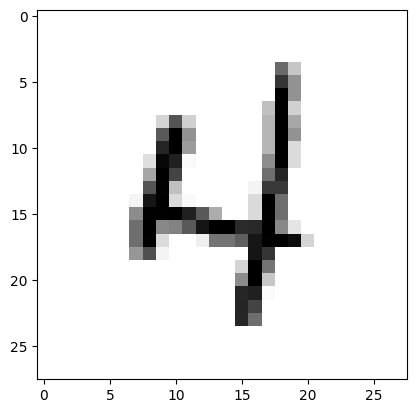

In [16]:

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

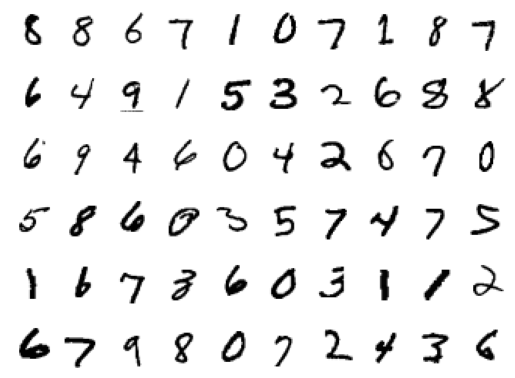

In [17]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
          Dropout-11           [-1, 20, 22, 22]               0
             ReLU-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1,

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
model =  Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.30838802456855774 Batch_id=937 Accuracy=88.88: 100%|██████████| 938/938 [00:48<00:00, 19.45it/s] 



Test set: Average loss: 0.1385, Accuracy: 9559/10000 (95.59%)

EPOCH: 1


Loss=0.07250597327947617 Batch_id=937 Accuracy=96.59: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s] 



Test set: Average loss: 0.0678, Accuracy: 9783/10000 (97.83%)

EPOCH: 2


Loss=0.06284409016370773 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:48<00:00, 19.44it/s]  



Test set: Average loss: 0.0489, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.011568133719265461 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:48<00:00, 19.20it/s] 



Test set: Average loss: 0.0417, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.0647403746843338 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:48<00:00, 19.32it/s]  



Test set: Average loss: 0.0402, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.03769763186573982 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:47<00:00, 19.70it/s]  



Test set: Average loss: 0.0387, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.003428423311561346 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:47<00:00, 19.74it/s] 



Test set: Average loss: 0.0369, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.12472216784954071 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:47<00:00, 19.76it/s]  



Test set: Average loss: 0.0308, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.018945548683404922 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:48<00:00, 19.44it/s] 



Test set: Average loss: 0.0304, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.008418785408139229 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s] 



Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.015679463744163513 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s] 



Test set: Average loss: 0.0314, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.009329350665211678 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:47<00:00, 19.59it/s] 



Test set: Average loss: 0.0341, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


Loss=0.041255585849285126 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:48<00:00, 19.25it/s] 



Test set: Average loss: 0.0312, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.012701318599283695 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:47<00:00, 19.74it/s] 



Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.2993452548980713 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]   



Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)



In [21]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

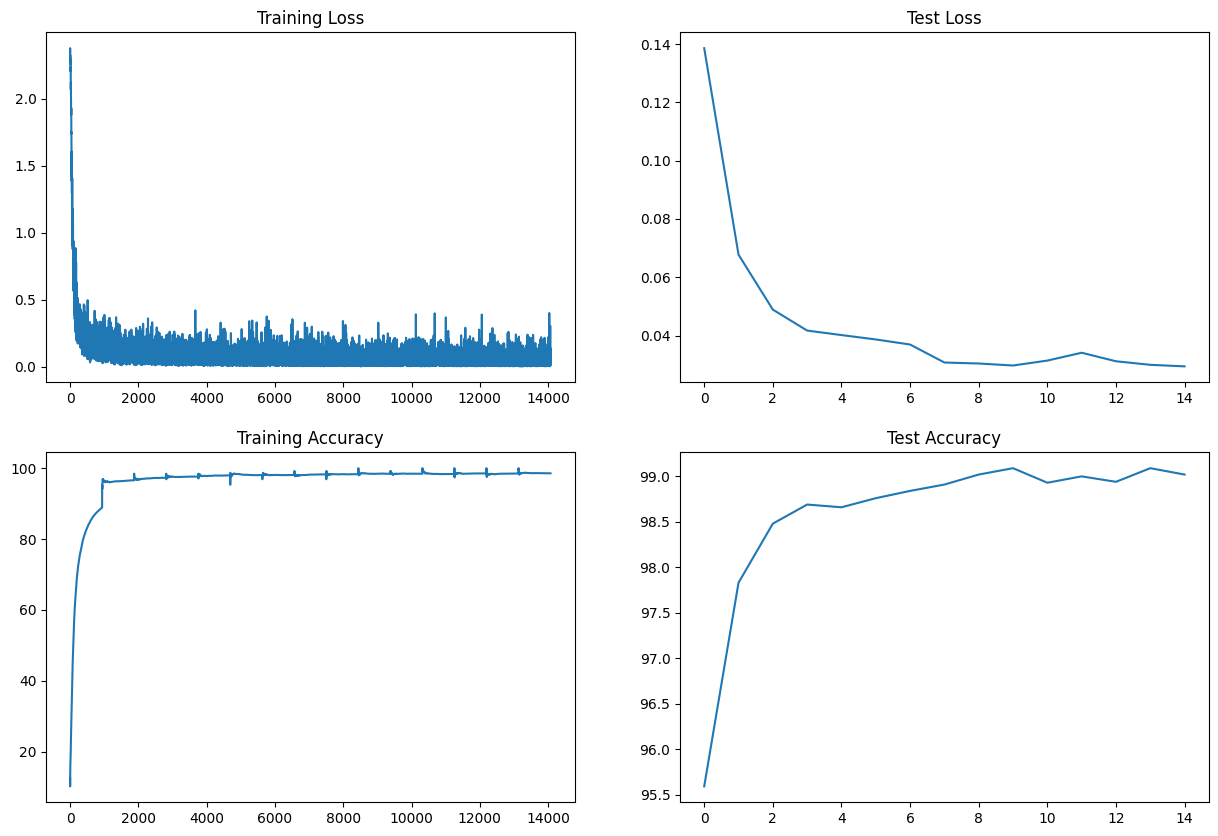

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
1) Added GAP
2) Added Dropout to all layer after Relu
3) Almost gain good result with less parameter then step_1

## Results:
1) Parameters: 9,434
2) Best Training Accuracy: 98.58
3) Best Test Accuracy: 99.09

## Analysis:
1) The model is pushed further up to 20 EPOCH, but it won't be able to get to 99.4
2) I have seen Under-fitting in model, I am updating the model in the next step with proper location of dropout and max pooling to get batter accuracy
 